In [6]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

class MessageState(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

In [7]:
initial_message=[AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on generative ai.", name="Krish")
                   ]
# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

add_messages(initial_message,new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='beb3e54c-1427-4e29-938e-f2d35e812181'),
 HumanMessage(content="I'm looking for information on generative ai.", additional_kwargs={}, response_metadata={}, name='Krish', id='2b327374-0af3-41e0-911f-e18c74e52bcb'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='e317ad0d-c6dc-4c90-aa87-b37e212bd9b2')]

Here we will create Langgraph using tools. We will use LLM brain to identify tools (i.e. add()) and then share result.

In [8]:
## Part 1 - set up LLM
import os
from dotenv import load_dotenv
load_dotenv()

##os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")


# from langchain_groq import ChatGroq
# llm = ChatGroq(model="gemma2-9b-it")
# llm

from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-3.5-turbo")
llm

ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x10eea7530>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x10da8f500>, root_client=<openai.OpenAI object at 0x10d9b6b70>, root_async_client=<openai.AsyncOpenAI object at 0x10eea7980>, model_kwargs={}, openai_api_key=SecretStr('**********'))

In [9]:
def add(a:int,b:int)-> int:
    """Add a and b.

    Args:
        a: first int
        b: second int
    """
    return a+b

In [10]:
llmBindWithTools = llm.bind_tools([add])

In [11]:
##Add tool as a node
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState


#node

def tool_calling_llm(state: MessagesState):
      return {"messages":[llmBindWithTools.invoke(state["messages"])]}



In [12]:
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools",ToolNode([add]))

builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
      "tool_calling_llm",
      # if the latest message (result) from assistant is a tool call -> tools condition routes to tools
      #if the latest message (result) from assistant is not a tool call -> tools condition routes to END

      tool_calling_llm
)

builder.add_edge("tools",END)
graph = builder.compile()



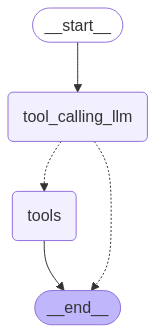

In [13]:
from IPython.display import Image,display
display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="Add 3 and 4. ")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}